In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def add_naive_forecast(df, target_col, months_back, start_date, horizon_months, text):
  
    forecast_col = f"Naive: {months_back}-Month for {text}"
    df[forecast_col] = np.nan

    start = pd.to_datetime(start_date)
    end = start + pd.DateOffset(months=horizon_months - 1)
    reference_date = start - pd.DateOffset(months=months_back)

    if reference_date in df.index:
        naive_value = df[target_col][df.index < start_date].iloc[-1]
        forecast_range = (df.index >= start) & (df.index <= end)
        df.loc[forecast_range, forecast_col] = naive_value

    return df


def getMetrics(df_d, df_r, date1, date2, forecast_type):
    month_name = pd.to_datetime(date1).strftime('%B')
    mask = (df_d.index >= date1) & (df_d.index <= date2)
    y_true = df_d.loc[mask, "Actual Rate"]
    y_pred = df_d.loc[mask, forecast_type]
    forecast_type_split = forecast_type.split(" f")
    if not y_true.isna().all() and not y_pred.isna().all():
        df_r.loc[month_name, f"{forecast_type_split[0]}: MAE"] = mean_absolute_error(y_true, y_pred)
        df_r.loc[month_name, f"{forecast_type_split[0]}: RMSE"] = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return df_r


MAE: 54520.31, RMSE: 62520.00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


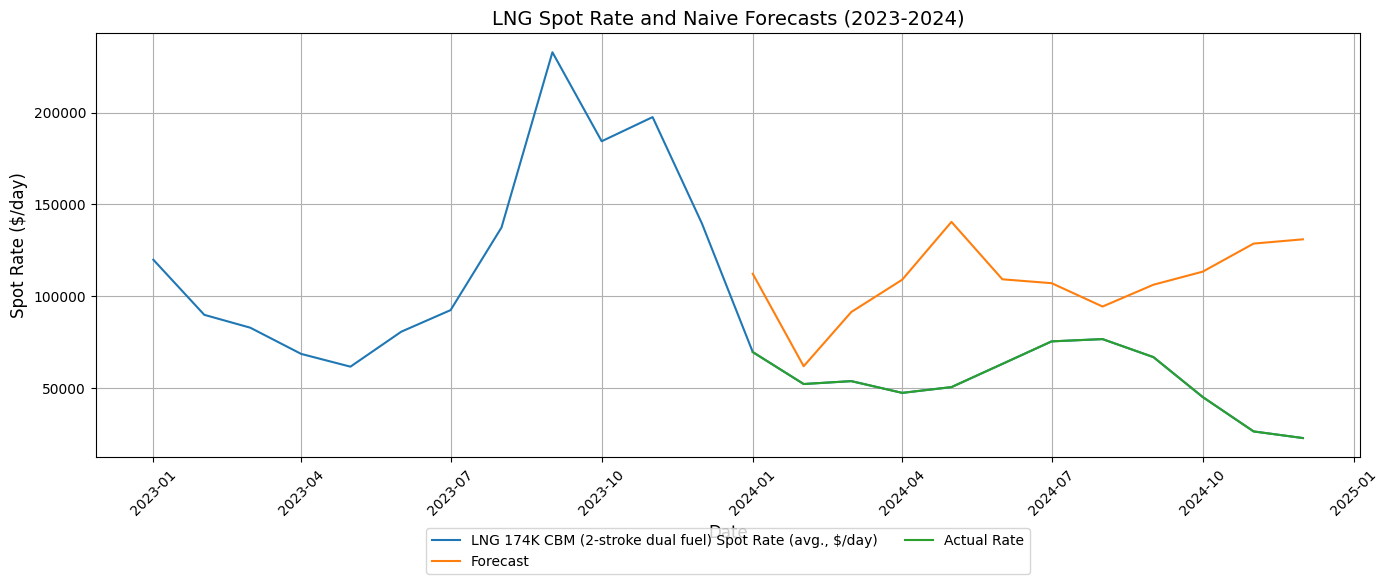

In [ ]:
# 12 Month all data

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'LNG Carrier Newbuilding Prices (end month, $m)',
                 'LNG Orderbook (start month, CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params
forecast_start_date = "2024-01-01"
forecast_end_date = "2024-12-01"
mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
df_forecast = df_clean[forecast_data].copy()



df_train = df_forecast[df_forecast.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
#display(df_train)

forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)

model = VAR(df_train)
results = model.fit(ic="aic")
forecast = results.forecast(df_train.values, steps=forecast_steps)

last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
recovered_forecast = np.exp(log_forecast_cumsum) 
df_forecast.loc[forecast_range, "Forecast"] = recovered_forecast
df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

#display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


MAE: 202771.28, RMSE: 234479.49


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


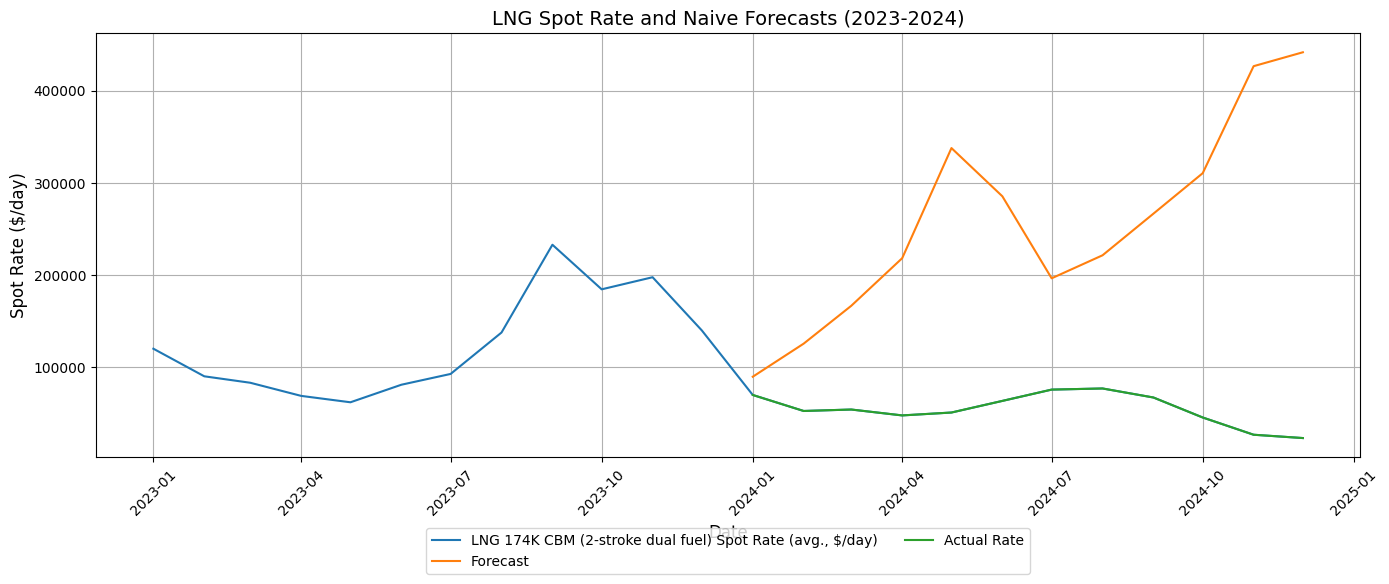

In [47]:
# 12 Month only rate and gas prices

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params
forecast_start_date = "2024-01-01"
forecast_end_date = "2024-12-01"
mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
df_forecast = df_clean[forecast_data].copy()



df_train = df_forecast[df_forecast.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
#display(df_train)

forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)

model = VAR(df_train)
results = model.fit(ic="aic")
forecast = results.forecast(df_train.values, steps=forecast_steps)

last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
recovered_forecast = np.exp(log_forecast_cumsum) 
df_forecast.loc[forecast_range, "Forecast"] = recovered_forecast
df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

#display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


MAE: 51120.73, RMSE: 60245.26


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


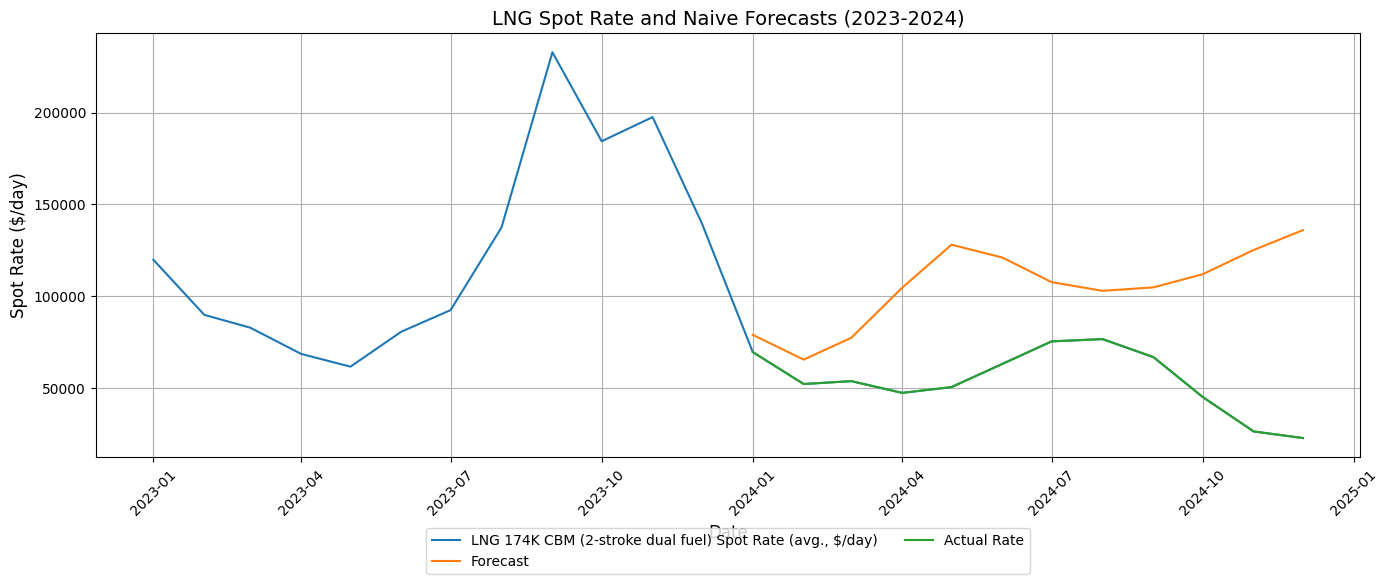

In [48]:
# 12 Month all data

from statsmodels.tsa.api import VAR

file_path = "../cleandata.csv"
df_clean = pd.read_csv(file_path)

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
forecast_data = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
                 'LNG Shipping Capacity (CBM)',
                 'Global price of Natural Gas, Asia (start month, MMBTU)',
                 'Global price of Natural Gas, EU (start month, MMBTU)',
                 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
                 'Spread\nEU-US',
                 'Spread\nASIA-US',
                 'Spread\nASIA-EU']
plotskip =  ['LNG Shipping Capacity (CBM)',
             'LNG Carrier Newbuilding Prices (end month, $m)',
             'LNG Orderbook (start month, CBM)',
             'Global price of Natural Gas, Asia (start month, MMBTU)',
             'Global price of Natural Gas, EU (start month, MMBTU)',
             'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
             'Spread\nEU-US',
             'Spread\nASIA-US',
             'Spread\nASIA-EU']

target = forecast_data[0]
#params
forecast_start_date = "2024-01-01"
forecast_end_date = "2024-12-01"
mask = (df_clean.index >= forecast_start_date) & (df_clean.index <= forecast_end_date)
df_forecast = df_clean[forecast_data].copy()



df_train = df_forecast[df_forecast.index < forecast_start_date]
df_train = np.log(df_train).diff().dropna()
#display(df_train)

forecast_range = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq="MS")
forecast_steps = len(forecast_range)

model = VAR(df_train)
results = model.fit(ic="aic")
forecast = results.forecast(df_train.values, steps=forecast_steps)

last_log_value = np.log(df_forecast.loc[df_train.index[-1], target])
df_temp_forecast = pd.DataFrame(forecast, index=forecast_range, columns=df_train.columns)
log_forecast_cumsum = df_temp_forecast[target].cumsum() + last_log_value  
recovered_forecast = np.exp(log_forecast_cumsum) 
df_forecast.loc[forecast_range, "Forecast"] = recovered_forecast
df_forecast.loc[df_forecast.index >= '2024-01-01', "Actual Rate"] = (df_forecast[target].loc[df_forecast.index >= '2024-01-01'])
plot_df = df_forecast.loc['2023-01-01':]


mae = mean_absolute_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"])
rmse = np.sqrt(mean_squared_error(df_forecast.loc[mask, "Actual Rate"], df_forecast.loc[mask,"Forecast"]))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

#display(df_forecast)
# Plotting
plt.figure(figsize=(14, 6))
for column in plot_df.columns:
    if column in plotskip:
        continue
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.title("LNG Spot Rate and Naive Forecasts (2023-2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spot Rate ($/day)", fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
